 # 102 Category Flower Dataset 💐💐

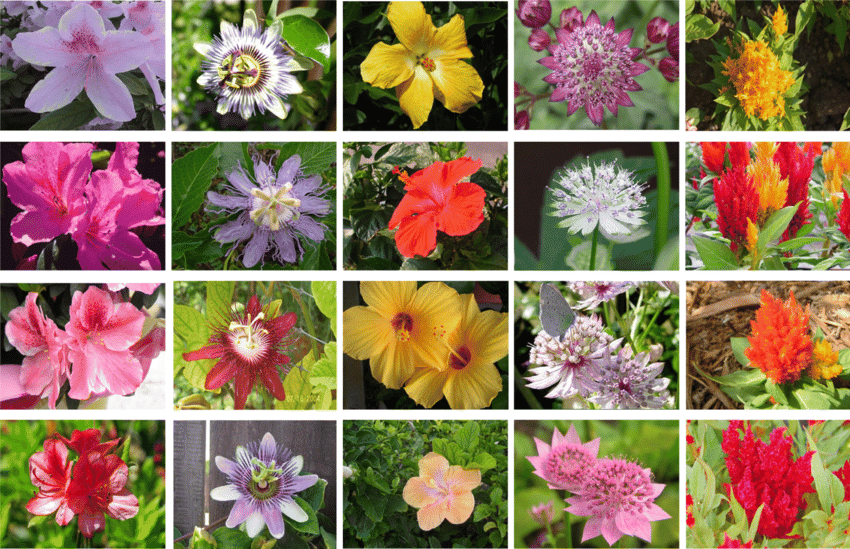

## Importing libraries

In [1]:
# Main Libraries
import numpy as np
import matplotlib.pyplot as plt
import torch
import os
import torchvision
# PyTorch Data Loading and Preprocesing Libraries
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor
from PIL import Image
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
from tqdm.auto import tqdm
from torch.utils.tensorboard import SummaryWriter
import pandas as pd
from sklearn.model_selection import train_test_split


## Loading Data and preprocess it

**Very Important Note**:

Our Data is Just a folder with 8189 picture of unlabeld Flowers.
So we need to make a custom Dataset


### Downloading the Data

In [4]:
!wget http://www.robots.ox.ac.uk/~vgg/data/flowers/102/102flowers.tgz
!tar -xzf 102flowers.tgz
!rm 102flowers.tgz
!wget http://www.robots.ox.ac.uk/~vgg/data/flowers/102/imagelabels.mat

--2024-04-08 19:34:22--  http://www.robots.ox.ac.uk/~vgg/data/flowers/102/102flowers.tgz
Resolving www.robots.ox.ac.uk (www.robots.ox.ac.uk)... 129.67.94.2
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://www.robots.ox.ac.uk/~vgg/data/flowers/102/102flowers.tgz [following]
--2024-04-08 19:34:23--  https://www.robots.ox.ac.uk/~vgg/data/flowers/102/102flowers.tgz
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://thor.robots.ox.ac.uk/datasets/flowers-102/102flowers.tgz [following]
--2024-04-08 19:34:24--  https://thor.robots.ox.ac.uk/datasets/flowers-102/102flowers.tgz
Resolving thor.robots.ox.ac.uk (thor.robots.ox.ac.uk)... 129.67.95.98
Connecting to thor.robots.ox.ac.uk (thor.robots.ox.ac.uk)|129.67.95.98|:443... connected.
HTTP request sent, awaiting respo

**Steps:**

* Load the labels of the images from a file named `imagelabels.mat`
* Convert the labels to a pandas dataframe
* Store the names of the images in folder jpg to a list
* Add the names of the images to the labels dataframe
* save the csv file to use it later when building the CustomDataset

### First Loading the labels and converting it to dataframe

In [5]:
# Load the labels of the images
from scipy.io import loadmat
imagelabel = loadmat('imagelabels.mat')

In [6]:
df=pd.DataFrame(imagelabel['labels'].T, columns=['label'])
df.head(5)

,label
0,77
1,77
2,77
3,77
4,77


In [7]:
from glob import glob

In [12]:
images=glob('./jpg/*.jpg')

In [13]:
df['images']=images
df

,label,images
0,77,./jpg/image_00853.jpg
1,77,./jpg/image_02254.jpg
2,77,./jpg/image_07130.jpg
3,77,./jpg/image_03946.jpg
4,77,./jpg/image_05037.jpg
...,...,...
8184,62,./jpg/image_05253.jpg
8185,62,./jpg/image_08104.jpg
8186,62,./jpg/image_04116.jpg
8187,62,./jpg/image_07997.jpg


In [14]:
df['label'].value_counts()

label
51    258
77    251
46    196
73    194
89    184
     ... 
27     40
34     40
1      40
21     40
45     40
Name: count, Length: 102, dtype: int64

### Spliting Data

In [15]:
X_train, X_test, y_train, y_test = train_test_split(df['images'], df['label'], test_size=0.2, random_state=42,shuffle=True)

## Creating the Custom Dataset

**Steps:**

* First we need to create a custom dataset class
* then we will load the dataset and split it into training and validation sets


### creating a custom dataset class

Note:
in this method we will use the csv file we made

In [16]:
class CustomFlowerDataset(Dataset):
    def __init__(self,images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)
    def __getitem__(self, idx):
        img_name = self.images.iloc[idx]
        image = Image.open(img_name)
        label = self.labels.iloc[idx] - 1  # Adjust the labels

        if self.transform:
            image = self.transform(image)

        return image, label

## Load Dataset

In [17]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])


    ])
}
train_dataset = CustomFlowerDataset(X_train,y_train, transform=data_transforms['train'])
test_set = CustomFlowerDataset(X_test, y_test, transform=data_transforms['train'])

In [18]:
# Create a DataLoader
train_loader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(dataset=test_set, batch_size=32, shuffle=True)

In [19]:
# Check the number of samples in the train and test sets
len(train_loader)

205

## Visualize the Data

### Display a sample image

In [20]:
# Get a batch of training data
inputs,classes=next(iter(train_loader))


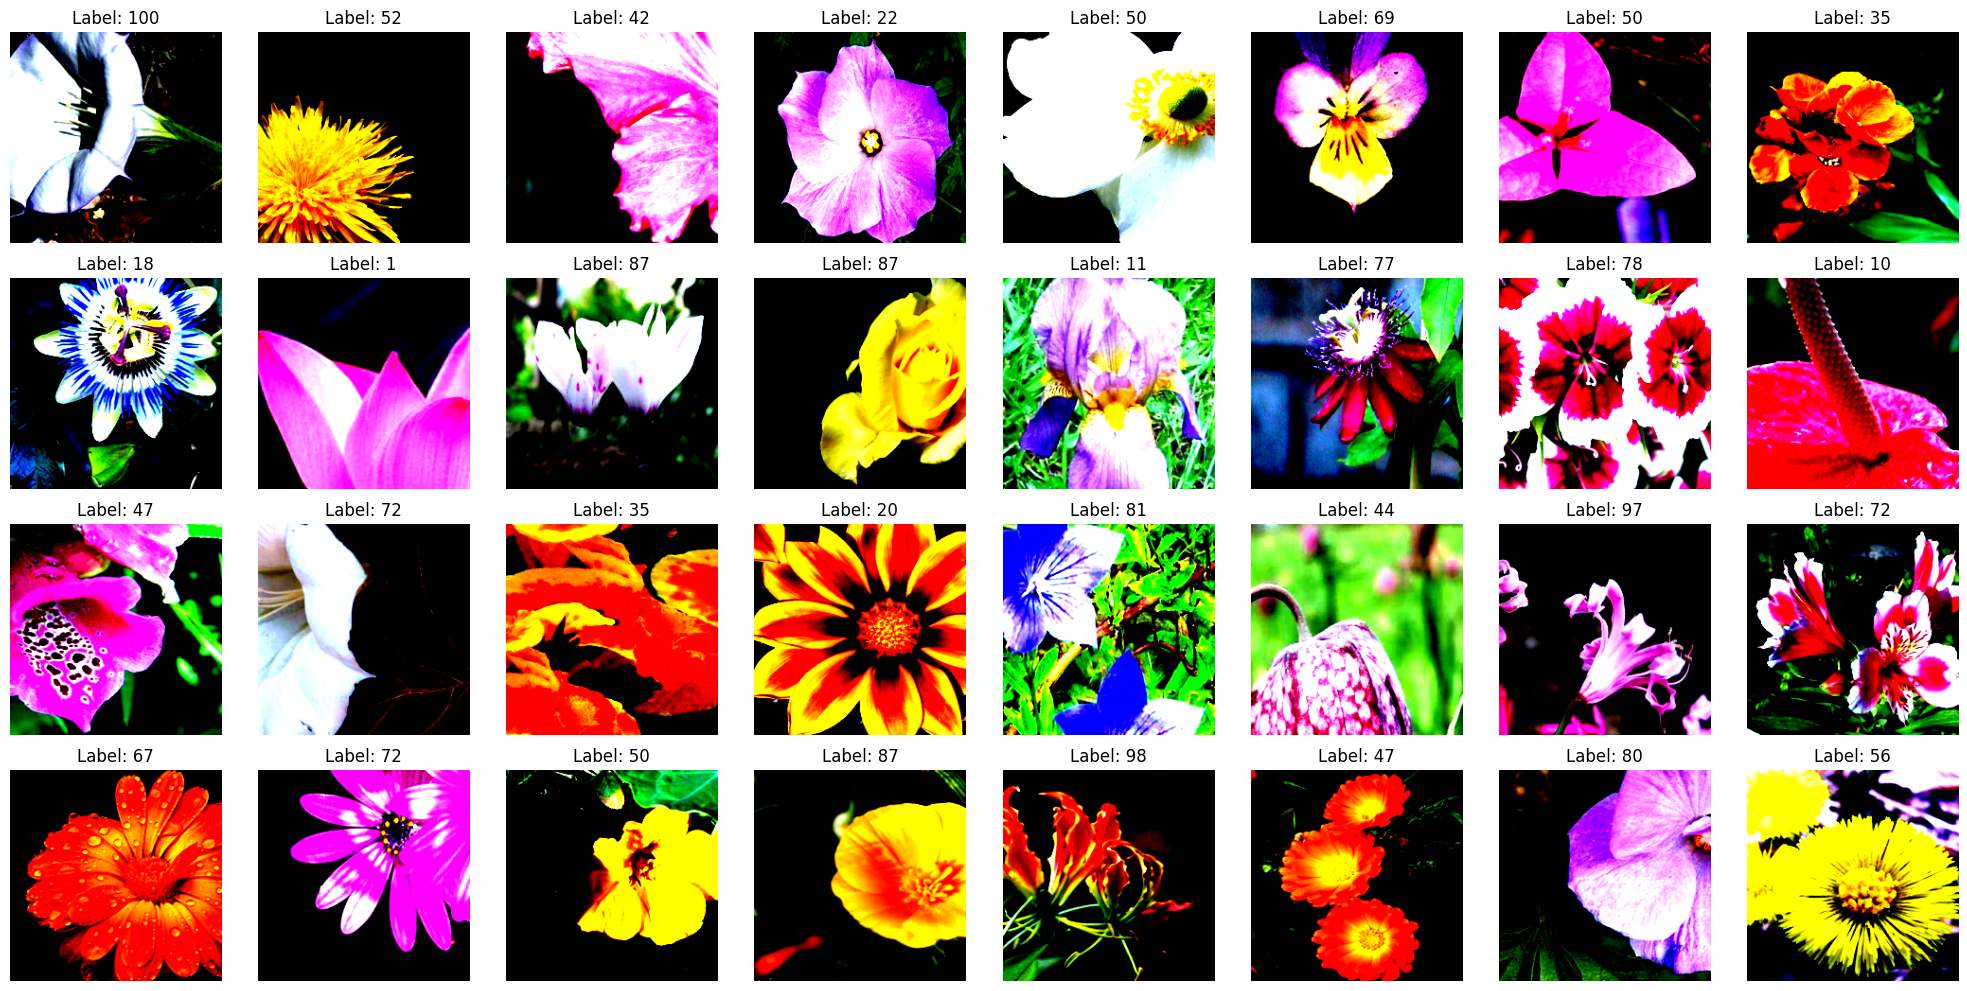

In [21]:
# Display the first batch of images and labels from the training data
fig, axes = plt.subplots(4, 8, figsize=(20, 10))
axes = axes.flatten()
# Display images and labels
for i in range(32):
    image, label = inputs[i], classes[i]
    image = image.permute(1, 2, 0)
    axes[i].imshow(image)
    axes[i].set_title(f"Label: {label}")
    axes[i].axis('off')
plt.tight_layout()
plt.show();

## Build the Model

### Simple Neural Network

In [48]:
class FlowerClassifier(nn.Module):
    def __init__(self):
        super(FlowerClassifier, self).__init__()
        # Define layers
        self.fc1 = nn.Linear(3 * 224 * 224, 256)  # Input layer
        self.relu = nn.ReLU()  # Activation function
        self.dropout = nn.Dropout(p=0.2)  # Dropout for regularization
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 102)  # Output layer

    def forward(self, x):
        # Flatten input
        x = x.view(x.size(0), -1)

        # Forward pass through layers
        x = self.relu(self.fc1(x))
        x = self.dropout(x)  # Apply dropout
        x = self.relu(self.fc2(x))
        x = self.fc3(x)

        return x

In [23]:
# Create an instance of the model
model = FlowerClassifier()
model

FlowerClassifier(
  (fc1): Linear(in_features=150528, out_features=256, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.2, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=102, bias=True)
)

Optimizing

In [24]:
# Define the loss function and the optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [25]:
# Check if a GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [26]:
# Move the model to the GPU
model.to(device)

FlowerClassifier(
  (fc1): Linear(in_features=150528, out_features=256, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.2, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=102, bias=True)
)

#### Training Neural Network

In [27]:
num_epochs = 10
for epoch in range(num_epochs):
    loop = tqdm(enumerate(train_loader), total=len(train_loader), leave=False)
    for batch_idx, (data, targets) in loop:
        data = data.to(device=device)
        targets = targets.to(device=device)

        # forward pass
        scores = model(data)
        loss = criterion(scores, targets)

        # backward pass
        optimizer.zero_grad()
        loss.backward()

        # gradient descent or adam step
        optimizer.step()

        loop.set_description(f"Epoch [{epoch}/{num_epochs}]")
        loop.set_postfix(loss=loss.item())



  0%|          | 0/205 [00:00<?, ?it/s]

  0%|          | 0/205 [00:00<?, ?it/s]

  0%|          | 0/205 [00:00<?, ?it/s]

  0%|          | 0/205 [00:00<?, ?it/s]

  0%|          | 0/205 [00:00<?, ?it/s]

  0%|          | 0/205 [00:00<?, ?it/s]

  0%|          | 0/205 [00:00<?, ?it/s]

  0%|          | 0/205 [00:00<?, ?it/s]

  0%|          | 0/205 [00:00<?, ?it/s]

  0%|          | 0/205 [00:00<?, ?it/s]

#### Evaluation

In [28]:
# Check the accuracy on the training and test sets
def check_accuracy(loader, model):
    num_correct = 0
    num_samples = 0
    model.eval()

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device)
            y = y.to(device=device)

            scores = model(x)
            _, predictions = scores.max(1)
            num_correct += (predictions == y).sum()
            num_samples += predictions.size(0)

    model.train()
    return f"{num_correct}/{num_samples}"

In [29]:
print(f"Accuracy on training set: {check_accuracy(train_loader, model)}")
print(f"Accuracy on test set: {check_accuracy(test_loader, model)}")

Accuracy on training set: 204/6551
Accuracy on test set: 54/1638


#### Saving Model

In [30]:
# Save the model
torch.save(model.state_dict(), 'flower_model.pth')

## Transfer Learning (Vgg Model)

In [31]:
# Load the pre-trained model
# we will use the vgg model
# Define the vgg model
vgg = models.vgg16(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:03<00:00, 151MB/s]


In [32]:
# Freeze the parameters
for param in vgg.parameters():
    param.requires_grad = False

In [33]:
# Modify the output layer
vgg.classifier[6] = nn.Linear(4096, 102)

In [34]:
# Move the model to the GPU
vgg.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [35]:
# Define the loss function and the optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(vgg.parameters(), lr=0.001)

#### Training Model

In [36]:
# Train the model
num_epochs = 10
writer = SummaryWriter('runs/loss_plot')
running_loss = 0.0
for epoch in range(num_epochs):
    loop = tqdm(enumerate(train_loader), total=len(train_loader), leave=False)
    for batch_idx, (data, targets) in loop:
        data = data.to(device=device)
        targets = targets.to(device=device)

        # forward pass
        scores = vgg(data)
        loss = criterion(scores, targets)

        # backward pass
        optimizer.zero_grad()
        loss.backward()

        # gradient descent or adam step
        optimizer.step()

        running_loss += loss.item()

    loop.set_description(f"Epoch [{epoch}/{num_epochs}]")
    loop.set_postfix(loss=loss.item())
    writer.add_scalar('training loss', running_loss/len(train_loader), epoch)

    running_loss = 0.0

  0%|          | 0/205 [00:00<?, ?it/s]

  0%|          | 0/205 [00:00<?, ?it/s]

  0%|          | 0/205 [00:00<?, ?it/s]

  0%|          | 0/205 [00:00<?, ?it/s]

  0%|          | 0/205 [00:00<?, ?it/s]

  0%|          | 0/205 [00:00<?, ?it/s]

  0%|          | 0/205 [00:00<?, ?it/s]

  0%|          | 0/205 [00:00<?, ?it/s]

  0%|          | 0/205 [00:00<?, ?it/s]

  0%|          | 0/205 [00:00<?, ?it/s]

#### Evaluation

In [37]:
# Check the accuracy on the training and test sets
print(f"Accuracy on training set: {check_accuracy(train_loader, vgg)}")

Accuracy on training set: 1245/6551


#### Saving Model

In [38]:
# Save the model
torch.save(vgg.state_dict(), 'flower_model_vgg.pth')

In [39]:
# Load the model
model = FlowerClassifier()
model.load_state_dict(torch.load('flower_model.pth'))
model.eval()

FlowerClassifier(
  (fc1): Linear(in_features=150528, out_features=256, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.2, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=102, bias=True)
)

## Making prediction

In [40]:
# make predictions
def predict_image(img, model):
    model.eval()
    img = img.unsqueeze(0)
    with torch.no_grad():
        prediction = model(img)
        prediction = torch.argmax(prediction).item()
    return prediction

I downloaded daisy image from internet `image.jpg`

In [51]:


image = Image.open('image.jpg')
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
image = transform(image).unsqueeze(0)
prediction = predict_image(image, model)
print(prediction)


50


# Thank you ❤️❤️